# Hands-on session #2

In this lab, we will used  **unsupervised methods** to differentiate between two Chinese Neolithic color-painted pottery:
- Banpo (5th to 4th millennium B.C.)
- Banshan(4th to 3rd millennium B.C.) .

<img src="./img/logo.jpeg" width="600" height="300">

**Topics covered in this session include:**
- Image clustering with deep learning: Ancient Chinese pottery
- Feature extraction with pre-trained deep learning models
- Data dimensionality reduction
    - PCA
    - t-SNE
- Clustering techniques:
    - Hierarchical clustering
    - k-Means
    - Gaussian Mixture Models
- Visualisation


The dataset used in this lab is described in the following work. All data credits go to the manuscript authors:

Zhao, Xiaohan, et al. "From classification to matching: A CNN-based approach for retrieving painted pottery images." Digital Applications in Archaeology and Cultural Heritage 29 (2023): e00269.

To download the dataset you can visit: 
https://data.mendeley.com/datasets/xnk7s6xgxz/1

In [1]:
'''
Splitting your dataset into train/validation/test sets.

This block defines a routine that takes the image directories from Banpo and Banshan images, and splits them into
40/15/45 % (train/validation/test subsets).  ''' 

import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Define directories
banpo_dir = './1-data/Banpo'
banshan_dir = './1-data/Banshan'

# Get list of images in each class directory
banpo_images = os.listdir(banpo_dir)
banshan_images = os.listdir(banshan_dir)

# Shuffle the images
np.random.shuffle(banpo_images)
np.random.shuffle(banshan_images)

# Split the images into train, validation, and test sets
banpo_train_size = int(0.4 * len(banpo_images)) #todo change values
banpo_val_size = int(0.15 * len(banpo_images))

banshan_train_size = int(0.4 * len(banshan_images))
banshan_val_size = int(0.15 * len(banshan_images))

banpo_train_images = banpo_images[:banpo_train_size]
banpo_val_images = banpo_images[banpo_train_size:banpo_train_size + banpo_val_size]
banpo_test_images = banpo_images[banpo_train_size + banpo_val_size:]

banshan_train_images = banshan_images[:banshan_train_size]
banshan_val_images = banshan_images[banshan_train_size:banshan_train_size + banshan_val_size]
banshan_test_images = banshan_images[banshan_train_size + banshan_val_size:]

# Create train, validation, and test directories
train_dir = './1-data/train'
val_dir = './1-data/val'
test_dir = './1-data/test'

# Create subdirectories for each class within train, validation, and test directories
train_banpo_dir = os.path.join(train_dir, 'Banpo')
train_banshan_dir = os.path.join(train_dir, 'Banshan')
val_banpo_dir = os.path.join(val_dir, 'Banpo')
val_banshan_dir = os.path.join(val_dir, 'Banshan')
test_banpo_dir = os.path.join(test_dir, 'Banpo')
test_banshan_dir = os.path.join(test_dir, 'Banshan')

os.makedirs(train_banpo_dir, exist_ok=True)
os.makedirs(train_banshan_dir, exist_ok=True)
os.makedirs(val_banpo_dir, exist_ok=True)
os.makedirs(val_banshan_dir, exist_ok=True)
os.makedirs(test_banpo_dir, exist_ok=True)
os.makedirs(test_banshan_dir, exist_ok=True)

# Function to copy images to destination directory
def copy_images(src_dir, dest_dir, images):
    for img in images:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.copyfile(src_path, dest_path)

# Copy images to train directory
copy_images(banpo_dir, train_banpo_dir, banpo_train_images)
copy_images(banshan_dir, train_banshan_dir, banshan_train_images)

# Copy images to validation directory
copy_images(banpo_dir, val_banpo_dir, banpo_val_images)
copy_images(banshan_dir, val_banshan_dir, banshan_val_images)

# Copy remaining images to test directory
copy_images(banpo_dir, test_banpo_dir, banpo_test_images)
copy_images(banshan_dir, test_banshan_dir, banshan_test_images)



2024-03-01 16:32:57.977155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
''' Data generators:
    Lets define train/valid/test data generators.
    
''' 

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
y_true = test_generator.labels


Found 227 images belonging to 2 classes.


**VGG16 AS FEATURE EXTRACTOR**

Let's use a pre-trained neural network as a feature extractor approach. The network we'll use is VGG16 (Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014))

We'll use the pretrained weights on ImageNet to directly extract features from our images. Note that under this approach, were we dont'have image labels, fine-tuning (as in lab #1) won't be performed.

**VGG16**
<img src="./img/vgg16.png" width="600" height="300">

Image source: Researchgate.net

In [3]:
''' Here we define VGG16 as the CNN backbone to use in our experiments. We are gonna used the weights pretrainned in ImageNet.
    Images will be directly passed through the network and features will be extracted from the last fully connected layer without
    re-training.
''' 

# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Define the layer from which you want to extract features
layer_name = 'predictions'  # This is a n=1000 features space layer.

# Create a model that outputs the activations of the specified layer
model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# Predict the test set images and extract features from the specified layer
features = model.predict(test_generator)
print('Features extracted')
print('Features dimension space:', features.shape)

8/8 [==============================] - 143s 18s/step
Features extracted
Features dimension space: (227, 1000)


# Dimensionality reduction techniques

The feature space (n=1000) extracted through VGG16 might be large for some applications. We aim to reduce the data dimensionality, ideally by preserving as much relevant information as possible.

We are gonna use two data dimensionality techniques: PCA and t-SNE.

With the help of GPT, answer: What is meant by 'the curse of dimensionality'? 

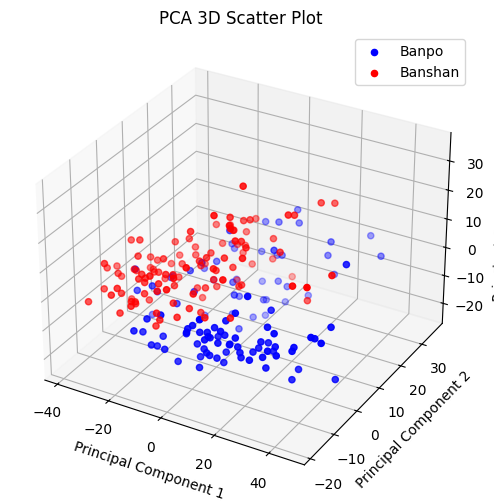

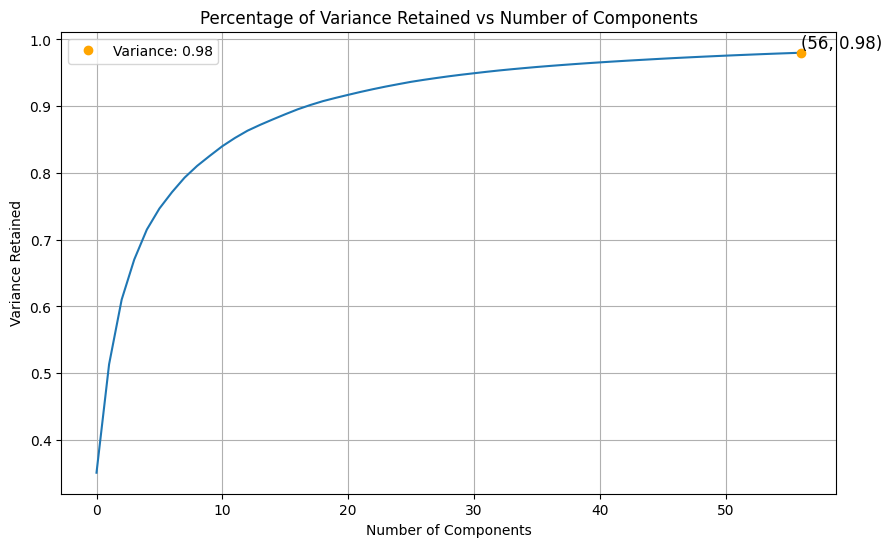

Number of principal components retained: 57


In [23]:
''' PRINCIPAL COMPONENT ANALYSIS.
    We'll reduce the feature space such that a large percentage of the data information is preserved.
    The idea is to move from a dimension space n = 1000 ---> m << 1000.

'''

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(data, variance_ratio=0.95):
    """
    Apply PCA to the input data and keep the components preserving
    the specified percentage of data variance.
    
    Parameters:
        data: array-like, shape (n_samples, n_features)
            Input data.
        variance_ratio: float, default=0.95
            Percentage of data variance to preserve.
    
    Returns:
        pca_features: array-like, shape (n_samples, n_components)
            Transformed features after PCA.
        pca: PCA object
            The trained PCA object for future use
    """
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(variance_ratio)
    pca_features = pca.fit_transform(data_scaled)
    return pca_features, pca

def plot_pca_scatter_3d(features_pca, y_true):
    """
    Plot the first three principal components in a 3D scatter plot.
    Colors of the points are determined by the binary vector y_true.
    
    Parameters:
        features_pca: array-like, shape (n_samples, 3)
            Features after PCA transformation.
        y_true: array-like, shape (n_samples,)
            Binary vector indicating true class labels.
    """
    label_colors = {0: 'blue', 1: 'red'}
    label_names = {0: 'Banpo', 1: 'Banshan'}
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(y_true):
        indices = y_true == label
        ax.scatter(features_pca[indices, 0], features_pca[indices, 1], features_pca[indices, 2], color=label_colors[label], label=label_names[label])
    ax.set_title('PCA 3D Scatter Plot')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
    plt.show()


def plot_variance_vs_components(pca, target_variance=0.98):
    """
    Plot the percentage of variance retained vs the number of retained principal components
    and mark the point where the target variance is reached with an orange dot.
    
    Parameters:
        pca: PCA object
            The trained PCA object
        target_variance: float, default=0.98
            The target percentage of variance to be retained
    """
    plt.figure(figsize=(10, 6))
    variance_retained = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(variance_retained)
    
    # Find the index where variance reaches the target_variance
    idx_target_variance = np.argmax(variance_retained >= target_variance)
    
    plt.plot(idx_target_variance, variance_retained[idx_target_variance], 'o', color='orange', label=f'Variance: {target_variance}')
    plt.text(idx_target_variance, variance_retained[idx_target_variance], f'({idx_target_variance}, {target_variance:.2f})', fontsize=12, verticalalignment='bottom')
    
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Retained')
    plt.title('Percentage of Variance Retained vs Number of Components')
    plt.grid(True)
    plt.legend()
    plt.show()



# Apply PCA and keep components preserving 95% of data variance
features_pca, pca = apply_pca(features, variance_ratio=0.98)

# Plot the first three principal components in a 3D scatter plot
plot_pca_scatter_3d(features_pca[:, :3], y_true)

# Plot variance vs components
plot_variance_vs_components(pca)
print('Number of principal components retained m=', features_pca.shape[1])

In [ ]:
''' Similar to PCA, we can used t-SNE to visualize our data in a lower dimensional space.
    With the help of chatGPT, use t-SNET to visualize the data in a 2D feature space. '''
from sklearn.manifold import TSNE

###  fill me in ###


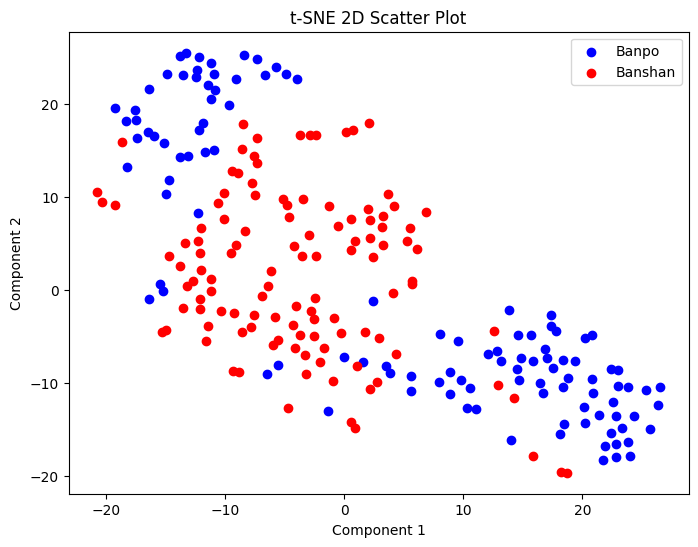

In [33]:
''' Visualizing the data in 2D with t-SNE -cheat sheet ''' 

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

# def apply_tsne(data, n_components=2, perplexity=30, learning_rate=200):
#     """
#     Apply t-SNE to the input data and reduce the dimensionality to the specified number of components.
    
#     Parameters:
#         data: array-like, shape (n_samples, n_features)
#             Input data.
#         n_components: int, default=2
#             Number of components in the reduced space.
#         perplexity: float, default=30
#             Perplexity parameter for t-SNE.
#         learning_rate: float, default=200
#             Learning rate parameter for t-SNE.
    
#     Returns:
#         tsne_features: array-like, shape (n_samples, n_components)
#             Transformed features after t-SNE.
#     """
#     scaler = StandardScaler()
#     data_scaled = scaler.fit_transform(data)
#     tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate)
#     tsne_features = tsne.fit_transform(data_scaled)
#     return tsne_features

# def plot_tsne_scatter_2d(features_tsne, y_true):
#     """
#     Plot the t-SNE features in a 2D scatter plot.
#     Colors of the points are determined by the binary vector y_true.
    
#     Parameters:
#         features_tsne: array-like, shape (n_samples, 2)
#             Features after t-SNE transformation.
#         y_true: array-like, shape (n_samples,)
#             Binary vector indicating true class labels.
#     """
#     label_colors = {0: 'blue', 1: 'red'}
#     label_names = {0: 'Banpo', 1: 'Banshan'}
#     plt.figure(figsize=(8, 6))
#     for label in np.unique(y_true):
#         indices = y_true == label
#         plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], color=label_colors[label], label=label_names[label])
#     plt.title('t-SNE 2D Scatter Plot')
#     plt.xlabel('Component 1')
#     plt.ylabel('Component 2')
#     plt.legend()
#     plt.show()

# # Apply t-SNE and reduce the dimensionality to 2 components
# features_tsne = apply_tsne(features, n_components=2, perplexity=20, learning_rate=100)

# # Plot the t-SNE features in a 2D scatter plot
# plot_tsne_scatter_2d(features_tsne, y_true)


### Image clustering

We'll use three unsupervised clusering techniques to differentiate our pottery images.
1) Hierarchical clustering
2) k-Means
3) Gaussian Mixture Models

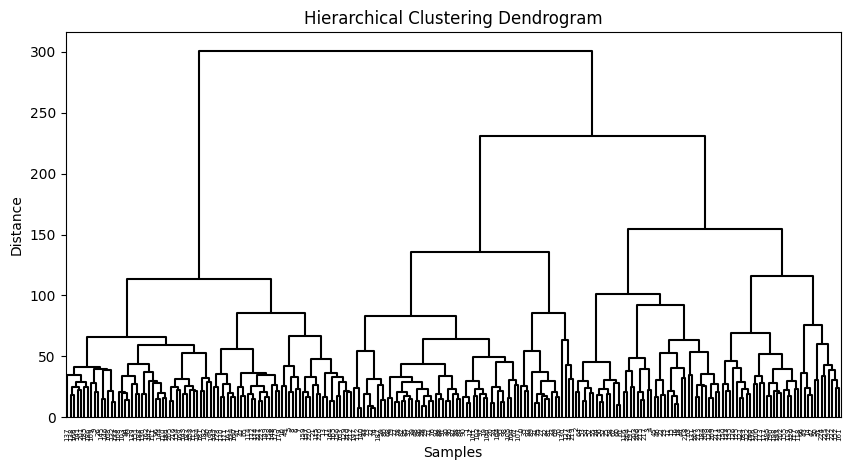

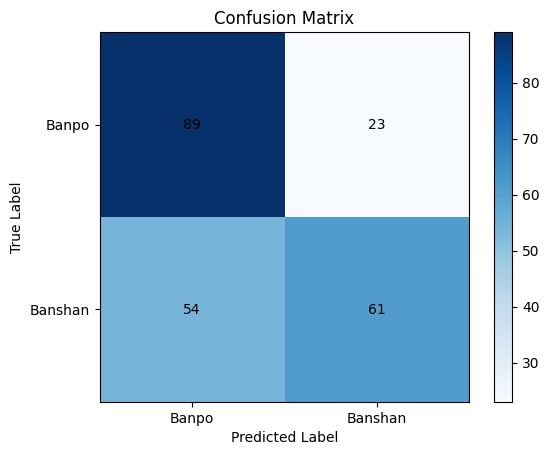

Accuracy: 0.3392070484581498
Sensitivity: 0.46956521739130436
Specificity: 0.20535714285714285


In [34]:
''' The following applies the hierarchical clustering algorithm on our data. '''

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.cluster import AgglomerativeClustering

# Apply hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2)
y_pred = clustering.fit_predict(features_pca)

# Generate dendrogram
linked = linkage(features_pca, method='ward')
plt.figure(figsize=(10, 5))

# Manually set color threshold to 2
dendrogram(linked, color_threshold=0, above_threshold_color='k')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Banpo', 'Banshan'])
plt.yticks([0, 1], ['Banpo', 'Banshan'])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
plt.show()

y_pred = 1 - y_pred  # inverting labels
# Calculate accuracy, sensitivity, and specificity
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(1 - y_true, 1 - y_pred)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


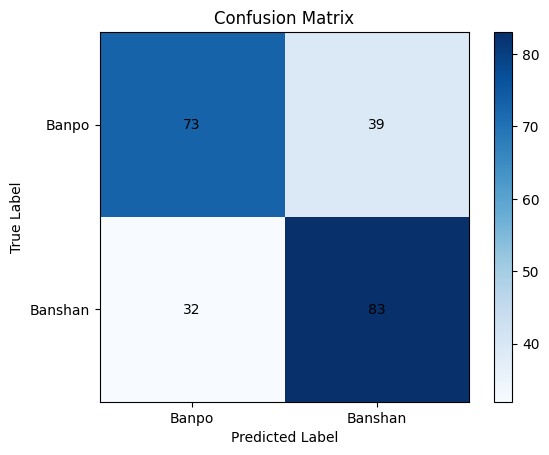

Accuracy: 0.6872246696035242
Sensitivity: 0.7217391304347827
Specificity: 0.6517857142857143


In [15]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(features_pca)
y_pred = kmeans.labels_

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0, 1], ['Banpo', 'Banshan'])
plt.yticks([0, 1], ['Banpo', 'Banshan'])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
plt.show()

# Calculate accuracy, sensitivity, and specificity
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)
specificity = recall_score(1 - y_true, 1 - y_pred)

print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


In [ ]:
''' Now, is your turn! Cluster your images using a Gaussian Mixtures Model (GMM), and measure the performance in terms of Accuracy,
    Sensitivity and Specificity. Conduct, also, a ROC analysis.
    
    Note: you want to fit two multivariate Gaussians, one for each pottery class.
    You can get help, as always, from GPT.'''

from sklearn.mixture import GaussianMixture

## fill me in ##

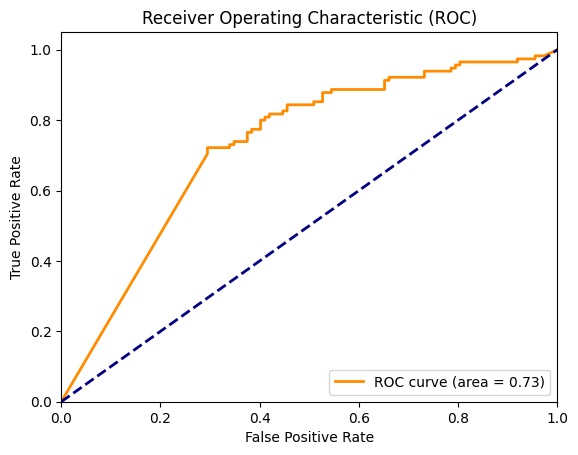

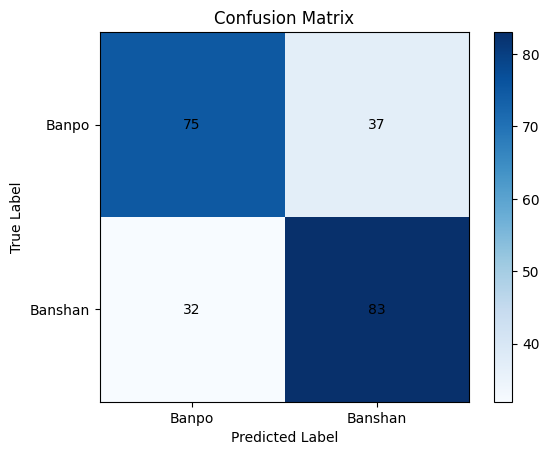

Accuracy: 0.6960352422907489
Sensitivity: 0.7217391304347827
Specificity: 0.6696428571428571


In [27]:
''' Gaussian mixture models: Cheat-sheet ''' 

# ''' Our third unsupervised clustering technique: GMM.
#     In this block, we'll fit 2 multivariate gaussian representing the two pottery image types. 

#     We'll compute the ROC curve of our models.
#     Question: How can we obtain a ROC curve for the k-Means algorithm used above?
# '''


# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# # Apply Gaussian Mixture Model clustering
# gmm = GaussianMixture(n_components=2, random_state=42)
# gmm.fit(features_pca)
# proba = gmm.predict_proba(features_pca)[:, 1]  # Probability of belonging to class 1

# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(y_true, proba)
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc='lower right')
# plt.show()

# # Calculate confusion matrix
# y_pred = gmm.predict(features_pca)
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix
# plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.xticks([0, 1], ['Banpo', 'Banshan'])
# plt.yticks([0, 1], ['Banpo', 'Banshan'])
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='black')
# plt.show()
# # Calculate accuracy, sensitivity, and specificity
# accuracy = accuracy_score(y_true, y_pred)
# sensitivity = recall_score(y_true, y_pred)
# specificity = recall_score(1 - y_true, 1 - y_pred)

# print("Accuracy:", accuracy)
# print("Sensitivity:", sensitivity)
# print("Specificity:", specificity)

### Translating these models to your own research.
**Objective:**  
Collaborate with 2-3 peers to explore image clustering using a real-world data problem.

**Instructions:**
1. Team-up with 2-3 classmates. At least one of you should have image data to be classified/clustered.
2. Re-use the deep-learning routines described above to extract features from your images. You may try VGG16 as backbone or any other neural network (e.g. ResNet).
3. Apply a dimensionality reduction technique to your feature space.
4. Classify your image samples using any of the clustering techniques described above.
5. Plot images from each class and assess the predicted labels. Are they correct and make sense?
6. If your dataset has ground-truth labels, calculate the accuracy, sensitivity, specificity and, when possible, plot ROC curves.   